# Algorytmy genetyczne - problem Komiwojażera

### Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.spatial import distance_matrix

### Funkcja generująca punkty

In [2]:
def generate_cities(n_cities, area_size):
    return pd.DataFrame({"X": np.random.randint(area_size, size=n_cities), "Y": np.random.randint(area_size, size=n_cities)})

(-10.0, 210.0)

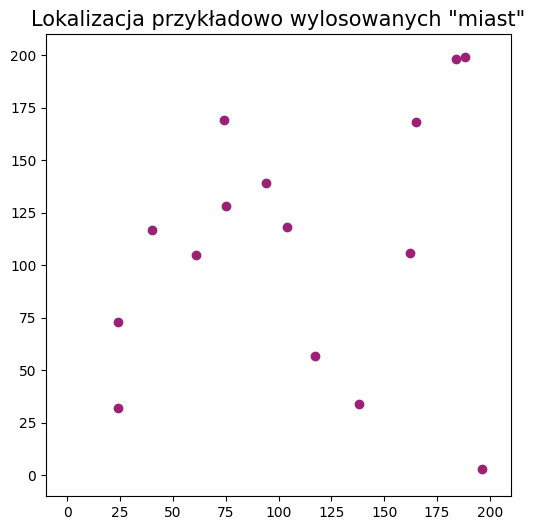

In [3]:
cities = generate_cities(15, 200)
plt.figure(figsize = (6,6))
plt.scatter(cities.X, cities.Y, color="#9B2177")
plt.title('Lokalizacja przykładowo wylosowanych "miast"', fontsize=15)
plt.xlim(-10,210)
plt.ylim(-10,210)

### Przedstawienie koordynatów

In [4]:
display(cities.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
X,24,61,196,138,184,24,94,162,75,117,40,165,74,104,188
Y,32,105,3,34,198,73,139,106,128,57,117,168,169,118,199


### Macierz dystansu

In [5]:
def distances(cities):
    return pd.DataFrame(distance_matrix(cities.values, cities.values), index=cities.index, columns=cities.index)

### Wybór populacji początkowej

In [6]:
def genesis(cities, num_individuals):
    n_cities = len(cities)
    population_set = []
    for i in range(num_individuals):
        city = np.random.permutation(list(range(1, n_cities)))
        population_set.append(city)
    population_df = pd.DataFrame(population_set, columns=['City_' + str(i) for i in range(1, n_cities)])
    return population_df

### Ocena populacjii

In [7]:
def compute_fitness(population_df, distance_matrix):
    fitness_values = []
    for idx, solution in population_df.iterrows():
        solution_distance = 0
        for i in range(len(solution) - 1):
            city1 = solution.iloc[i]
            city2 = solution.iloc[i + 1]
            solution_distance += distance_matrix.loc[city1, city2]
        first_city = solution.iloc[0]
        last_city = solution.iloc[len(solution) - 1]
        solution_distance += distance_matrix.loc[0, first_city]
        solution_distance += distance_matrix.loc[last_city, 0]
        fitness_values.append(solution_distance)
    return fitness_values

### Selekcja - metoda ruletki

In [8]:
def roulette_selection(fitness_list, population_df):
    inverse_fitness_list = 1 / np.array(fitness_list)
    total_fit = inverse_fitness_list.sum()
    prob_list = inverse_fitness_list/total_fit
    parents_indices = np.random.choice(list(range(len(population_df))), size=2, p=prob_list, replace=True)
    return population_df.loc[parents_indices[0],:], population_df.loc[parents_indices[1],:]

### Selekcja - metoda rankingowa

In [9]:
def ranking_selection(fitness_list, population_df):
    min_indices = np.argsort(fitness_list)[:2]
    selected_population = population_df.iloc[min_indices].copy()

    return selected_population.iloc[0], selected_population.iloc[1]

### Krzyżowanie

In [10]:
def fix_duplicates(child, n_cities):
    city_counts = child.value_counts()
    duplicates = city_counts[city_counts > 1]
    missing_cities = list(set(range(1,n_cities)) - set(child))
    for duplicate in duplicates.index:
        duplicate_indices = [i for i, x in enumerate(child) if x == duplicate]
        for idx in duplicate_indices:
            if missing_cities:
                child.iloc[idx] = missing_cities.pop()
    return child

In [11]:
def crossover(parent_a, parent_b, crossover_prob):
    n_cities = len(parent_a)
    if np.random.rand() < crossover_prob:
        start_point = np.random.randint(0, n_cities - 1)
        end_point = np.random.randint(start_point + 1, n_cities)
        child_a = pd.concat([parent_a[:start_point],parent_b[start_point:end_point],parent_a[end_point:]])
        child_b = pd.concat([parent_b[:start_point],parent_a[start_point:end_point],parent_b[end_point:]])
        child_a = fix_duplicates(child_a, n_cities)
        child_b = fix_duplicates(child_b, n_cities)
    else:
        child_a, child_b = parent_a, parent_b
    return child_a, child_b

### Mutacja

In [12]:
def mutate(individ, mutation_prob = 0.8):
    if np.random.rand() < mutation_prob:
        n_cities = len(individ)
        idx1, idx2 = np.random.choice(n_cities, 2, replace=False)
        individ.iloc[idx1], individ.iloc[idx2] = individ.iloc[idx2], individ.iloc[idx1]
    return individ

### Generowanie nowej populacji

In [13]:
def create_new_generation(current_population_df, fitness_values, num_individuals, crossover_prob, mutation_prob, selection_type='roulette'):
    new_generation = []

    while len(new_generation) < num_individuals:
        if selection_type == 'roulette':
            parent_1, parent_2 = roulette_selection(fitness_values, current_population_df)
        elif selection_type == 'ranking':
            parent_1, parent_2 = ranking_selection(fitness_values, current_population_df)

        child_1, child_2 = crossover(parent_1, parent_2, crossover_prob)
        child_1 = mutate(child_1, mutation_prob)
        child_2 = mutate(child_2, mutation_prob)
        new_generation.extend([child_1, child_2])
    
    new_generation_df = pd.DataFrame(new_generation, columns=current_population_df.columns).reset_index(drop=True)
    return new_generation_df

## Implementacja algorytmu genetycznego

In [14]:
def genetic_algorithm(num_cities, num_individuals, generations, mutation_rate=0.02, crossover_rate=0.8, area_size=200):
    cities = generate_cities(num_cities, area_size)
    dist = distances(cities)
    population = genesis(cities.index, num_individuals)
    
    best_fitness_over_generations = []
    avg_fitness_over_generations = []
    median_fitness_over_generations = []
    all_fitness_scores = []

    for generation in range(generations):
        fitness = compute_fitness(population, dist)
        best_fitness_over_generations.append(min(fitness))
        avg_fitness_over_generations.append(np.mean(fitness))
        median_fitness_over_generations.append(np.median(fitness))
        all_fitness_scores.append(fitness)
        population = create_new_generation(population, fitness, num_individuals, crossover_rate, mutation_rate)
    best_idx = np.argmin(fitness)
    best_individual = population.iloc[best_idx].values
    best_distance = fitness[best_idx]
    
    return best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, cities

### Najlepsza trasa w danym pokoleniu
#### Funkcja do wizualizacji

In [15]:
def best_route(best_individual, cities_df):
    x = [cities.X.loc[i] for i in best_individual]
    y = [cities.Y.loc[i] for i in best_individual]

    x.insert(0,cities.X.loc[0])
    y.insert(0,cities.Y.loc[0])

    x.append(cities.X.loc[0])
    y.append(cities.Y.loc[0])
    
    plt.figure(figsize=(6, 6))
    plt.plot(x,y, color="#efaffa")
    plt.scatter(cities_df["X"], cities_df["Y"], color="#8f00a8")
    plt.xlim(0, 210)
    plt.ylim(0, 210)
    plt.title("Najlepsza wyznaczona trasa w generacji")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

### Funkcja wizualizująca poprawę jakości

In [16]:
def plot_evolution(best_fitness, avg_fitness, median_fitness, generations):
    plt.figure(figsize=(10, 6))
    plt.plot(generations, best_fitness, 'bo-', label='Najlepszy wynik')
    plt.plot(generations, avg_fitness, 'go-', label='Średnia')
    plt.plot(generations, median_fitness, 'ro-', label='Mediana')
    plt.fill_between(generations, median_fitness, color='red', alpha=0.1)
    plt.xlabel('Pokolenia')
    plt.ylabel('Wartość funkcji jakości')
    plt.title('Ewolucja jakości w kolejnych pokoleniach')
    plt.legend()
    plt.grid(True)
    plt.show()

[ 7  3  6 13  8  5  2 11 12  1  9 10  2  9]
Najlepsza znaleziona trasa ma długość: 1008.3635415544394


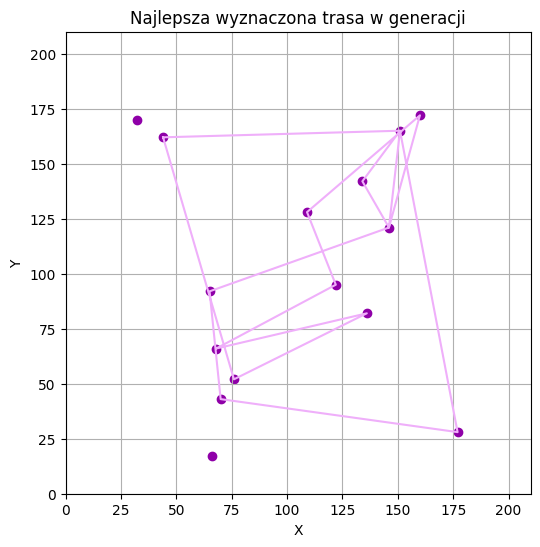

In [17]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, cities = genetic_algorithm(num_cities=15, num_individuals=50, generations=100, mutation_rate=0.01, crossover_rate=0.9)
print(best_individual)
best_route(best_individual, cities)
#plot_evolution(best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, generations=50)

print(f'Najlepsza znaleziona trasa ma długość: {best_distance}')